In [106]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib
from skglm import GeneralizedLinearEstimator
from skglm.penalties import MCPenalty
from skglm.datafits import Quadratic

matplotlib.rcParams.update({'font.size': 16})

In [43]:
company_table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]
stock_list = company_table['Ticker'].to_list()

In [3]:
start_time = '2017-01-01'
end_time = '2022-12-31'

stock_data = []
for idx in stock_list:
    temp_data = yf.download(idx, start=start_time, end=end_time)
    data_ = pd.DataFrame()
    data_[idx] = temp_data['Adj Close']
    stock_data.append(data_)

stock_data = pd.concat(stock_data, axis=1)
stock_data = stock_data.reset_index()
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format="%d-%m-%Y").dt.date
stock_data = stock_data.set_index('Date')

stock_data = stock_data.fillna(method='ffill')
stock_data = stock_data.fillna(method='bfill')

stock_pct = stock_data.pct_change()[1:]
stock_idx = stock_pct.index 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
nasdaq_data =  yf.download('^NDX', start=start_time, end=end_time)['Adj Close']

nasdaq_data = nasdaq_data.fillna(method='ffill')
nasdaq_data = nasdaq_data.fillna(method='bfill')

nasdaq_pct = nasdaq_data.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


In [6]:
def loss_fn(X, w, b):
    '''
    params:
        X: np.array, [T, N]
        w: np.array, [N,]
        b: np.array, [T ]

    return:
        obj: np.array, [T, 1]
    '''
        
    T = X.shape[0]
    
#     print(X.shape, w.shape, b.shape)
    
    loss = cp.norm(X @ w - b, 2) ** 2
    obj = loss / T
    
    return obj

In [7]:
def solve_quadratic_program(X, y):
    '''
    params:
        X: np.array, [T, N]
        y: np.array, [T, 1]
        w: np.array, [N, 1]
        b: np.array, [T, 1]
    
    return:
        w: np.array, [N, 1]
    '''
    
    
    
    T, N = X.shape
    
    w = cp.Variable(N)
    one_vec = np.ones(N)
    
    h = np.ones(1)
    b = np.zeros(N)
    
    problem = cp.Problem(cp.Minimize(loss_fn(X, w, y)), 
                        [one_vec @ w == h,
                         w >= b])
    problem.solve()
    res = w.value
    
    return res

In [111]:
train_widnow = 100
test_window = 30

X = stock_pct.values * 100
y = nasdaq_pct.values * 100


T = X.shape[0]
y_est_dict = {}

y_gt_list = []
y_est_list = []

alphas = [i for i in np.arange(0.1, 0.9, 0.1)]
# alphas = [0.8]
gammas = [1.1]

for _, gamma in enumerate(gammas):
    for idx, alpha in enumerate(alphas):
        alpha = round(alpha, 3)
        gamma = round(gamma, 1)
        model = GeneralizedLinearEstimator(Quadratic(), MCPenalty(alpha=alpha, gamma=gamma))

        for i in range(train_widnow, T - test_window, test_window):
            X_train = X[i - train_widnow:i, :]
            y_train = y[i - train_widnow:i]

            X_test = X[i:i + test_window, :]
            y_test = y[i:i + test_window]

            ## solve the L1/2 regularized problem
            model.fit(X_train, y_train)
            w_est_init = model.coef_

            w_indxs = np.argwhere(w_est_init > 0).flatten()
            w_est = np.zeros(w_est_init.shape[0])

            X_new = X_train[:, w_indxs].squeeze()
            if len(X_new.shape) != 2:
                continue
            w_est_ls = solve_quadratic_program(X_new, y_train)
            w_est[w_indxs] = w_est_ls

            y_est = X_test.dot(w_est)

            y_est_list.append(y_est)
            y_gt_list.append(y_test)

        y_res = np.concatenate(y_est_list)
        y_gt = np.concatenate(y_gt_list)
        
        key = 'alpha=' + str(alpha) + ' ' + 'gamma=' + str(gamma) 
        y_est_dict[key] = y_res

        y_est_list = [] 
        y_gt_list = []

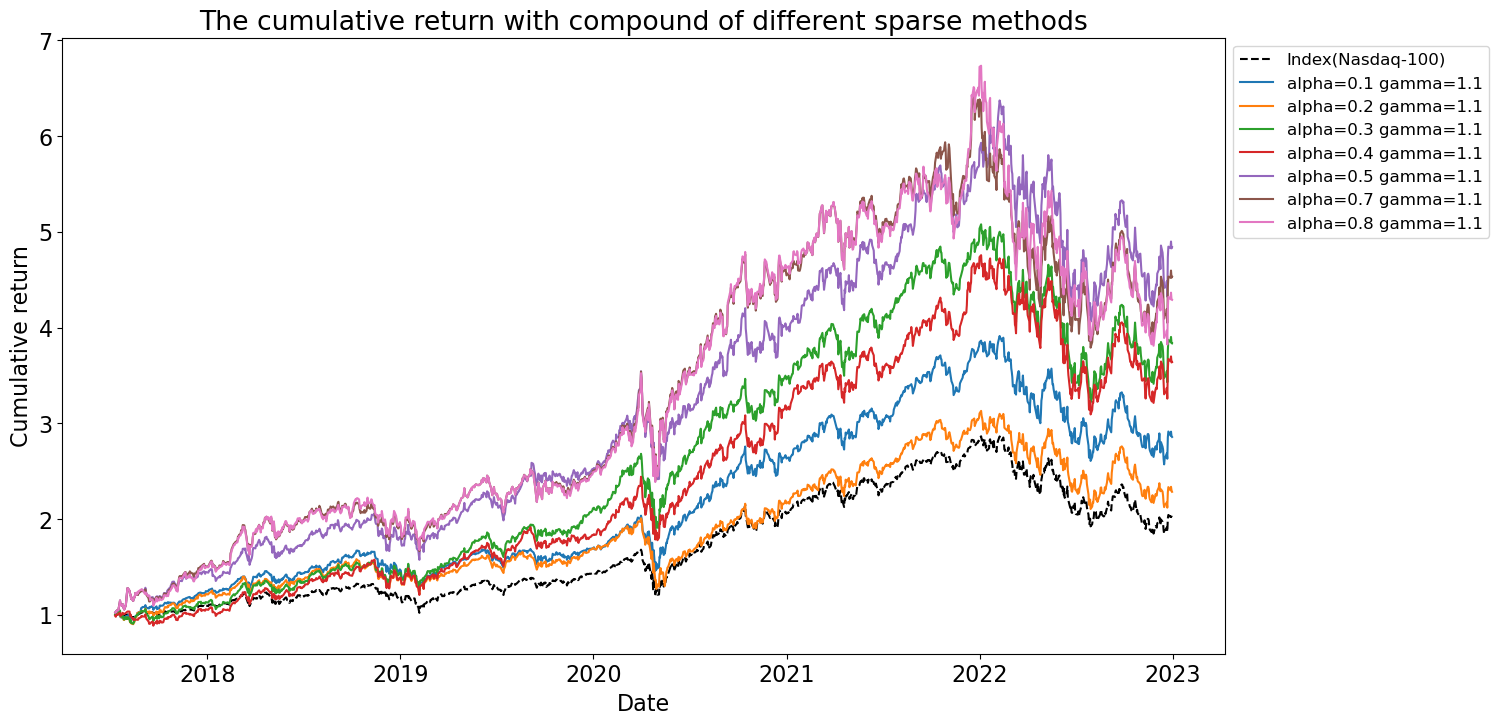

In [113]:
plt.figure(figsize=(15, 8))
indx = stock_idx[train_widnow + test_window-1:]
plt.plot(indx, np.cumprod(1 + y_gt/100), '--', color='black', label = 'Index(Nasdaq-100)')


for key, val in y_est_dict.items():
    if val.shape == indx.shape:
        plt.plot(indx, np.cumprod(1+ val/100), label=str(key))
plt.ylabel("Cumulative return")
plt.xlabel("Date")
plt.title("The cumulative return with compound of sparse methods with MC penalty")
plt.legend(bbox_to_anchor=(1.00, 1.0), loc='upper left', fontsize=12)
plt.show()

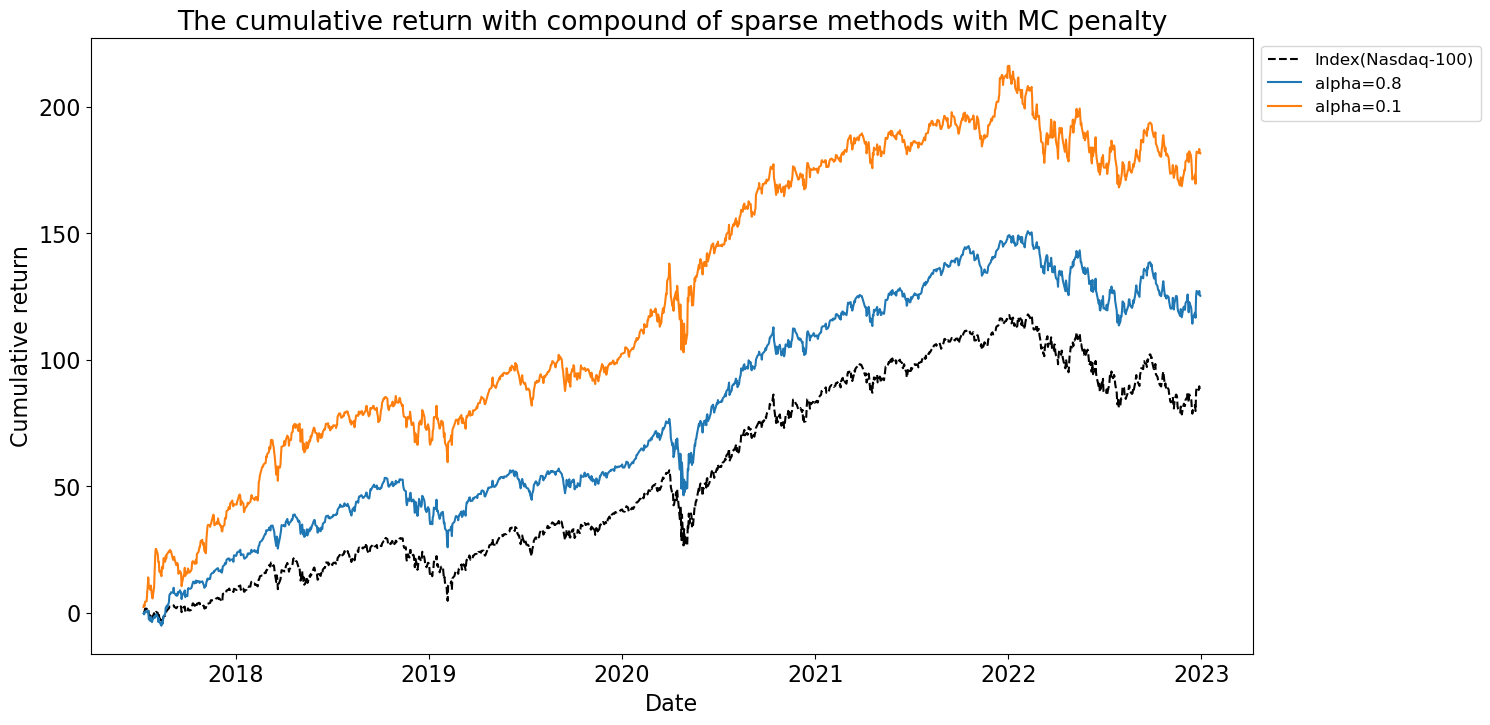

In [115]:
plt.figure(figsize=(15, 8))
plt.plot(indx, np.cumsum(y_gt), '--', color='black', label = 'Index(Nasdaq-100)')
plt.plot(indx, np.cumsum(y_est_dict['alpha=0.1 gamma=1.1']), label='alpha=' + str(0.8))
plt.plot(indx, np.cumsum(y_est_dict['alpha=0.8 gamma=1.1']), label='alpha=' + str(0.1))
plt.ylabel("Cumulative return")
plt.xlabel("Date")
plt.title("The cumulative return with compound of sparse methods with MC penalty")
plt.legend(bbox_to_anchor=(1.00, 1.0), loc='upper left', fontsize=12)
plt.show()